# Import Libraries

In [1]:
#import libraries 
import os
import zipfile
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import circmean, circstd

In [2]:
#install netcdf
!conda install -y netcdf4

Jupyter detected...
3 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.



In [15]:
# Load and merge all NetCDF hindcast files into one dataset
bad_file = "waves_point_465809.0_lon151.400_lat-22.467_all_months.nc"
folder = "wave_hindcast_point"

good_files = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.endswith(".nc") and f != bad_file
]

print(f"Good files found: {len(good_files)}")

ds_all = xr.open_mfdataset(
    good_files,
    combine="nested",
    concat_dim="point",
    chunks="auto",
    engine="netcdf4",
    parallel=False
)

ds_all

Good files found: 473


<xarray.Dataset> Size: 33MB
Dimensions:    (point: 473, time: 2904)
Coordinates:
    longitude  (point) float32 2kB 151.6 151.7 151.7 151.8 ... 152.0 152.1 152.1
    latitude   (point) float32 2kB -24.0 -24.0 -24.0 ... -22.47 -22.47 -22.47
  * time       (time) datetime64[ns] 23kB 2024-12-01 ... 2025-03-31T23:00:00....
Dimensions without coordinates: point
Data variables:
    hs         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    t02        (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    fp         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    dir        (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    dp         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    cge        (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
Attributes: (12/17)
    WAVEWATCH_III_version_number:           4.18b
    WAVEWATCH_III_switches:                 F90 NOGRB LRB4 DIST MPI NOPA UQ P...
    SIN4 namelist parameter BETAMAX:        1.33
    SDS4 namelist parameter WHITECAPWIDTH:  0.3
    product_name:                           ww3.aus_4m.202412.nc
    area:                                   4 min Australian grid
    ...                                     ...
    easternmost_longitude:                  175.0000000
    minimum_altitude:                       -12000 m
    maximum_altitude:                       9000 m
    altitude_resolution:                    n/a
    start_date:                             2024-12-01T00:00:00Z
    stop_date:                              2024-12-31T23:00:00Z

# Extract information from data 
### Mathematically transform meta data to derive further hydrodynamic conditions 

In [16]:
# Convert the full hindcast dataset (all points) into a single DataFrame
df = ds_all.to_dataframe().dropna().reset_index()

# Check structure
print(df.head())
print(df.columns)
print(f"Total records: {len(df)} | Unique points: {df['point'].nunique()}")

   point                          time     hs   t02     fp        dir    dp  \
0      0 2024-12-01 00:00:00.000000000  0.264  4.43  0.122  45.600002  50.0   
1      0 2024-12-01 00:59:59.999986560  0.294  4.55  0.121  47.000000  52.0   
2      0 2024-12-01 02:00:00.000013440  0.272  4.25  0.123  44.700001  50.0   
3      0 2024-12-01 03:00:00.000000000  0.298  4.25  0.122  45.900002  52.0   
4      0 2024-12-01 03:59:59.999986560  0.280  3.65  0.124  42.799999  49.0   

   cge   longitude  latitude  
0  0.2  151.600266 -23.99987  
1  0.3  151.600266 -23.99987  
2  0.2  151.600266 -23.99987  
3  0.3  151.600266 -23.99987  
4  0.2  151.600266 -23.99987  
Index(['point', 'time', 'hs', 't02', 'fp', 'dir', 'dp', 'cge', 'longitude',
       'latitude'],
      dtype='object')
Total records: 1370676 | Unique points: 472


In [17]:
# Derive key parameters
rho = 1025
g = 9.81

df["P_kWm"] = (0.5 * rho * g**2 * (df["hs"]**2) * df["t02"]) / (64 * np.pi) / 1000
df["L_m"] = (g * df["t02"]**2) / (2 * np.pi)
df["Steepness"] = df["hs"] / df["L_m"]
df["Hs_T02_ratio"] = df["hs"] / df["t02"]

In [18]:
# Filter to study period
study_start = "2025-02-01"
study_end   = "2025-03-31"
df_study = df.loc[study_start:study_end].copy()

### Make sure time is in timestamp format 

In [19]:
print(df.index)
print(df.index.dtype)

RangeIndex(start=0, stop=1370676, step=1)
int64


In [20]:
# Ensure datetime index
# Replace 'time' with the actual column name that stores timestamps
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")
else:
    raise ValueError("No 'time' column found in df; cannot set datetime index.")

# Quick check
print("Datetime index set successfully.")
print("Index range:", df.index.min(), "to", df.index.max())

Datetime index set successfully.
Index range: 2024-12-01 00:00:00 to 2025-03-31 23:00:00.000013440


### Detect cyclone using Peak over Threshold
### Using a Boolean Series (Scans for True/False values)

In [21]:
# Ensure dataframe uses datetime index
if not np.issubdtype(df.index.dtype, np.datetime64):
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
    else:
        raise ValueError("No 'time' column found to set as datetime index.")

# Helper function
def find_runs(mask: pd.Series, min_duration: pd.Timedelta):
    """Return list of (start, end) for contiguous True runs meeting min_duration."""
    runs = []
    if mask.empty:
        return runs
    # Label contiguous segments
    groups = (mask != mask.shift()).cumsum()
    for _, seg in mask.groupby(groups):
        if seg.iloc[0]:  # only True runs
            start, end = seg.index[0], seg.index[-1]
            duration = end - start
            if duration >= min_duration:
                runs.append([start, end])
    return runs

# Threshold rules
threshold_2m = 2.0
threshold_3m = 3.0
min_duration = pd.Timedelta("3D")  # 3 days
merge_gap    = pd.Timedelta("1D")  # merge events closer than 1 day

# Boolean masks 
mask_low  = df["hs"] > threshold_2m
mask_high = df["hs"] > threshold_3m

# Candidate runs 
runs_low  = find_runs(mask_low,  min_duration)
runs_high = find_runs(mask_high, pd.Timedelta("0D"))

# --- Merge and sort all candidate intervals ---
events = sorted(runs_low + runs_high, key=lambda x: x[0])

# Merge events separated by < 1 day 
merged = []
for s, e in events:
    if not merged:
        merged.append([s, e])
    else:
        prev_s, prev_e = merged[-1]
        if s - prev_e < merge_gap:   # too close → merge
            merged[-1][1] = max(prev_e, e)
        else:
            merged.append([s, e])

events = merged

# Print summary 
print(f"Detected {len(events)} storm event(s) by PoT rules:")
for s, e in events:
    dur = (e - s) / pd.Timedelta("1D")
    max_hs = df.loc[(df.index >= s) & (df.index <= e), "hs"].max()
    print(f"Event: {s:%Y-%m-%d %H:%M} → {e:%Y-%m-%d %H:%M}  |  Duration: {dur:.1f} days  |  Max Hs: {max_hs:.2f} m")

Detected 4 storm event(s) by PoT rules:
Event: 2024-12-18 18:59 → 2024-12-19 17:00  |  Duration: 0.9 days  |  Max Hs: 3.50 m
Event: 2025-01-04 08:00 → 2025-01-04 12:59  |  Duration: 0.2 days  |  Max Hs: 3.16 m
Event: 2025-02-01 09:00 → 2025-02-05 20:00  |  Duration: 4.5 days  |  Max Hs: 2.91 m
Event: 2025-02-20 09:00 → 2025-03-06 09:00  |  Duration: 14.0 days  |  Max Hs: 7.31 m


Cyclone Alfred period in CBG: 2025-02-20 09:59:59 → 2025-03-07 09:00:00
Duration: 15.0 days
Records in subset: 169920


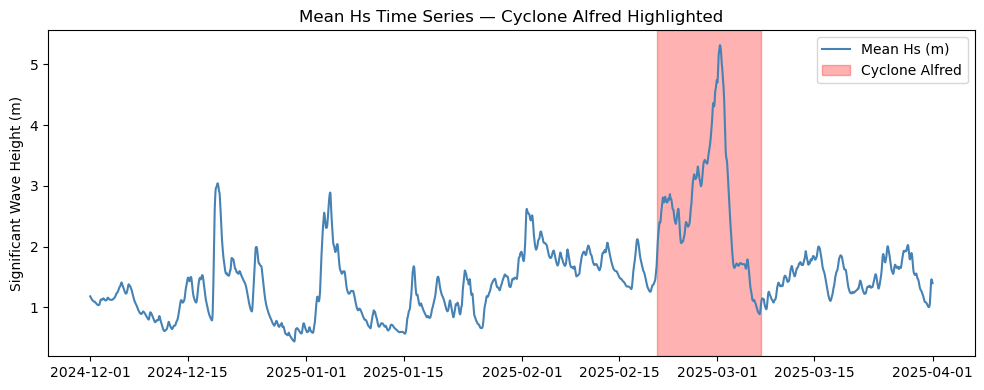

In [22]:
# Select only Cyclone Alfred 
alfred_start = pd.Timestamp("2025-02-20 09:59:59")
alfred_end   = pd.Timestamp("2025-03-07 09:00:00")

# Subset dataframe to Alfred event
df_cyclone = df[(df.index >= alfred_start) & (df.index <= alfred_end)].copy()

print(f"Cyclone Alfred period in CBG: {alfred_start} → {alfred_end}")
print(f"Duration: {(alfred_end - alfred_start) / pd.Timedelta('1d'):.1f} days")
print(f"Records in subset: {len(df_cyclone)}")

# Mean Hs time series across all hindcast points
df_mean = df.groupby("time")["hs"].mean()

plt.figure(figsize=(10,4))
plt.plot(df_mean.index, df_mean, color="steelblue", lw=1.5, label="Mean Hs (m)")
plt.axvspan(alfred_start, alfred_end, color="red", alpha=0.3, label="Cyclone Alfred")
plt.ylabel("Significant Wave Height (m)")
plt.title("Mean Hs Time Series — Cyclone Alfred Highlighted")
plt.legend()
plt.tight_layout()
plt.show()

# Create data
### Summary of statistics and create the time series

In [23]:
# Recreate study period subset with datetime-aware filtering
study_start = pd.Timestamp("2025-02-01 00:00:00")
study_end   = pd.Timestamp("2025-03-31 23:59:59")

df_study = df[(df.index >= study_start) & (df.index <= study_end)].copy()

print(f"Study period subset: {df_study.index.min()} → {df_study.index.max()}")
print(f"Records in study period: {len(df_study)}")

Study period subset: 2025-02-01 00:00:00 → 2025-03-31 23:00:00.000013440
Records in study period: 668352


In [24]:
def deg_to_compass(deg):
    """Convert degrees to 16-point compass direction (e.g., N, NE, ESE)."""
    dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
            "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    ix = int((deg % 360) / 22.5)
    return dirs[ix]

def make_summary(df_subset):
    """Generate summary stats for key and derived parameters, with circular handling for direction."""
    variables = ["hs", "t02", "tp", "fp", "dp", "dir", "cge",
                 "P_kWm", "Steepness", "Hs_T02_ratio"]
    summary_data = []

    for var in variables:
        if var not in df_subset.columns:
            continue

        # Handle circular (directional) variables 
        if var in ["dp", "dir"]:
            mean_val = circmean(df_subset[var], high=360, low=0)
            std_val = circstd(df_subset[var], high=360, low=0)

            # Dominant direction (mode of rounded 10° bins)
            if not df_subset[var].dropna().empty:
                dominant_dir = df_subset[var].round(-1).mode().iloc[0]
                dominant_compass = deg_to_compass(dominant_dir)
            else:
                dominant_dir = np.nan
                dominant_compass = ""

            summary_data.append({
                "Variable": var,
                "Units": "°",
                "Mean": mean_val,
                "Median": np.nan,
                "Min": np.nan,
                "Max": np.nan,
                "Std_Dev": std_val,
                "Dominant_Direction": dominant_dir,
                "Dominant_Compass": dominant_compass
            })

        # Handle all other linear variables 
        else:
            summary_data.append({
                "Variable": var,
                "Units": (
                    ds_all[var].attrs.get("units", "")
                    if var in ds_all.data_vars
                    else ("kW/m" if var == "P_kWm" else "—")
                ),
                "Mean": df_subset[var].mean(),
                "Median": df_subset[var].median(),
                "Min": df_subset[var].min(),
                "Max": df_subset[var].max(),
                "Std_Dev": df_subset[var].std(),
                "Dominant_Direction": np.nan,
                "Dominant_Compass": ""
            })

    return pd.DataFrame(summary_data)


#Generate summaries 
summary_study = make_summary(df_study)
summary_cyclone = make_summary(df_cyclone)

# Merge for side-by-side comparison
summary_combined = summary_study.merge(
    summary_cyclone,
    on=["Variable", "Units"],
    suffixes=("_StudyPeriod", "_CycloneAlfred")
)

# Reorder columns for clarity
summary_combined = summary_combined[
    ["Variable", "Units",
     "Mean_StudyPeriod", "Median_StudyPeriod", "Min_StudyPeriod", "Max_StudyPeriod",
     "Std_Dev_StudyPeriod", "Dominant_Direction_StudyPeriod", "Dominant_Compass_StudyPeriod",
     "Mean_CycloneAlfred", "Median_CycloneAlfred", "Min_CycloneAlfred", "Max_CycloneAlfred",
     "Std_Dev_CycloneAlfred", "Dominant_Direction_CycloneAlfred", "Dominant_Compass_CycloneAlfred"]
]

# Display and export 
print("Hydrodynamic Summary — Study Period vs Cyclone Alfred (Feb–Mar 2025)")
display(summary_combined.round(2))

summary_combined.to_csv("hindcast_summary_study_vs_alfred.csv", index=False)
print("Saved: hindcast_summary_study_vs_alfred.csv")

Hydrodynamic Summary — Study Period vs Cyclone Alfred (Feb–Mar 2025)


,Variable,Units,Mean_StudyPeriod,Median_StudyPeriod,Min_StudyPeriod,Max_StudyPeriod,Std_Dev_StudyPeriod,Dominant_Direction_StudyPeriod,Dominant_Compass_StudyPeriod,Mean_CycloneAlfred,Median_CycloneAlfred,Min_CycloneAlfred,Max_CycloneAlfred,Std_Dev_CycloneAlfred,Dominant_Direction_CycloneAlfred,Dominant_Compass_CycloneAlfred
0,hs,m,1.89,1.72,0.17,7.31,0.82,NaN,,2.66,2.61,0.17,7.31,1.20,NaN,
1,t02,s,5.22,4.97,2.13,10.36,0.98,NaN,,6.06,5.72,2.13,10.36,1.24,NaN,
2,fp,s-1,0.12,0.12,0.07,0.43,0.02,NaN,,0.10,0.10,0.07,0.42,0.02,NaN,
3,dp,°,98.21,NaN,NaN,NaN,15.57,100.0,E,102.48,NaN,NaN,NaN,20.34,100.0,E
4,dir,°,96.55,NaN,NaN,NaN,19.36,100.0,E,108.24,NaN,NaN,NaN,20.38,110.0,E
5,cge,kW m-1,16.46,9.70,0.10,282.60,24.73,NaN,,37.75,25.00,0.10,282.60,41.75,NaN,
6,P_kWm,kW/m,6.09,3.59,0.03,113.25,9.18,NaN,,13.93,9.63,0.03,113.25,15.51,NaN,
7,Steepness,—,0.04,0.05,0.00,0.07,0.01,NaN,,0.05,0.05,0.00,0.06,0.02,NaN,
8,Hs_T02_ratio,—,0.36,0.35,0.03,0.85,0.11,NaN,,0.43,0.47,0.03,0.85,0.15,NaN,


Saved: hindcast_summary_study_vs_alfred.csv


### Mean time series for each variable

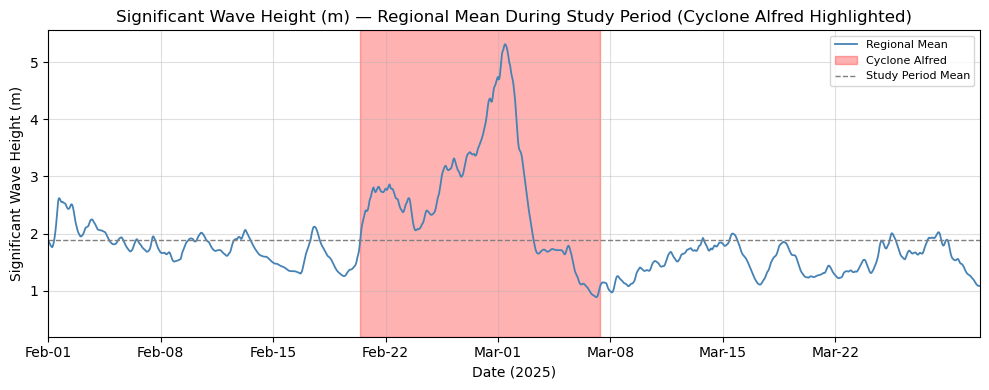

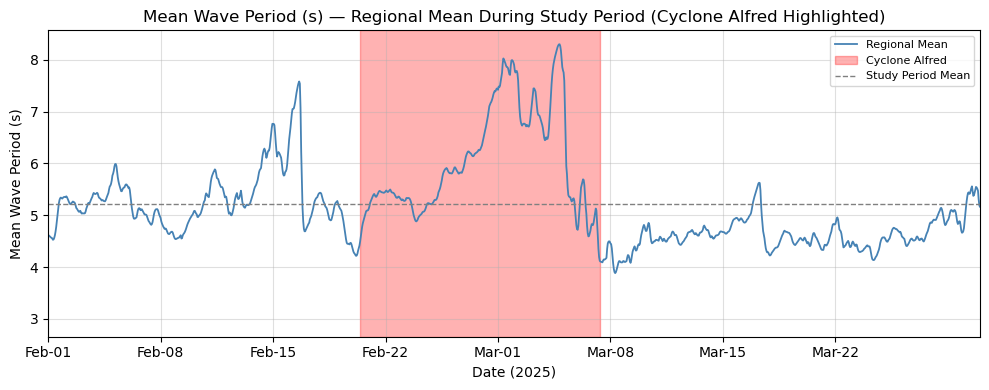

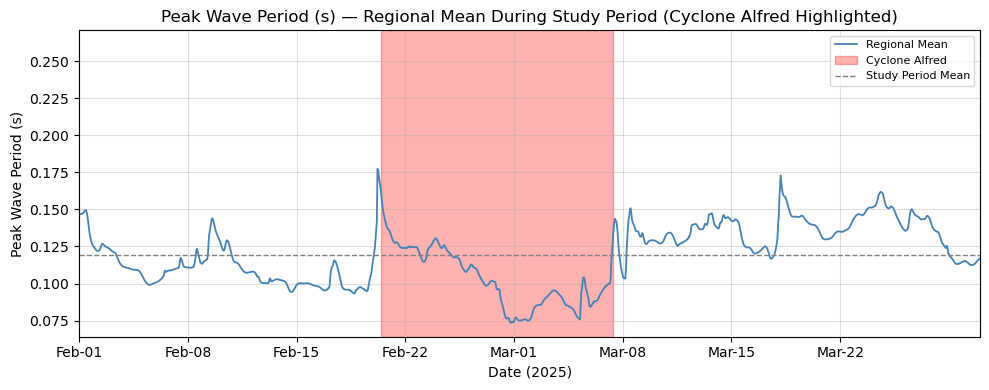

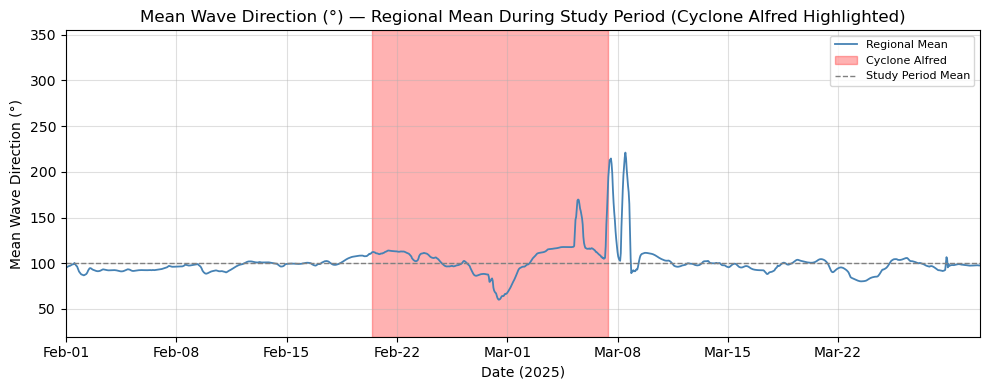

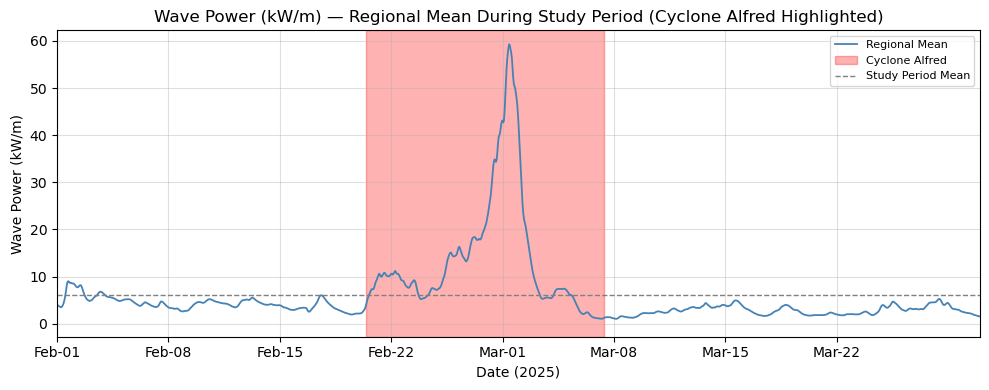

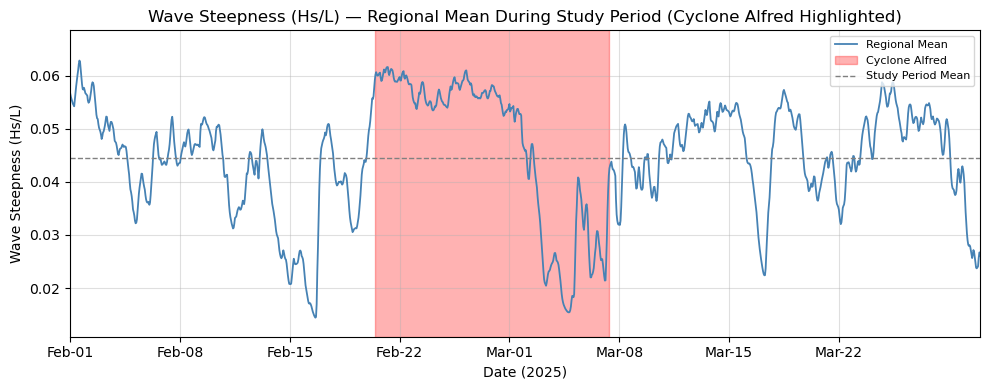

In [25]:
alfred_start = pd.Timestamp("2025-02-20 09:59:59")
alfred_end   = pd.Timestamp("2025-03-07 09:00:00")

plot_vars = [
    ("hs", "Significant Wave Height (m)"),
    ("t02", "Mean Wave Period (s)"),
     ("fp", "Peak Wave Period (s)"),
    ("dp", "Mean Wave Direction (°)"),
    ("P_kWm", "Wave Power (kW/m)"),
    ("Steepness", "Wave Steepness (Hs/L)")
]

# Define study period boundaries
study_start = pd.Timestamp("2025-02-01 00:00:00")
study_end   = pd.Timestamp("2025-03-31 23:59:59")

for var, label in plot_vars:
    if var in df.columns:
        # Compute regional mean across all hindcast points
        df_mean = df.groupby("time")[var].mean()

        # Compute study period mean
        study_mask = (df_mean.index >= study_start) & (df_mean.index <= study_end)
        study_mean_value = df_mean.loc[study_mask].mean()

        plt.figure(figsize=(10, 4))
        plt.plot(df_mean.index, df_mean, color="steelblue", linewidth=1.3, label="Regional Mean")
        plt.axvspan(alfred_start, alfred_end, color="red", alpha=0.3, label="Cyclone Alfred")
        plt.axhline(study_mean_value, color="gray", linestyle="--", linewidth=1.0, label="Study Period Mean")

        plt.ylabel(label)
        plt.title(f"{label} — Regional Mean During Study Period (Cyclone Alfred Highlighted)")
        plt.grid(alpha=0.4)
        plt.xlim(pd.Timestamp("2025-02-01"), pd.Timestamp("2025-03-31"))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
        plt.xlabel("Date (2025)")
        plt.legend(fontsize=8, loc="upper right")
        plt.tight_layout()

        # Optional: save each figure
        plt.savefig(f"{var}_MeanTimeseries_CycloneAlfred.png", dpi=150, bbox_inches="tight")
        plt.show()
    else:
        print(f"Variable '{var}' not found in dataframe.")

In [26]:
import zipfile
# Create a folder and zip all generated figures
output_folder = "Cyclone_Alfred_Figures"
os.makedirs(output_folder, exist_ok=True)

# Move all figure files into that folder
for var, _ in plot_vars:
    fig_name = f"{var}_MeanTimeseries_CycloneAlfred.png"
    if os.path.exists(fig_name):
        os.rename(fig_name, os.path.join(output_folder, fig_name))

# Create ZIP file
zip_filename = "Cyclone_Alfred_Figures.zip"
with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_folder):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, output_folder)
            zipf.write(file_path, arcname)

print(f"\n All figures saved and zipped as '{zip_filename}'.")
print("You can now download it from your Jupyter environment.")


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'hs_MeanTimeseries_CycloneAlfred.png' -> 'Cyclone_Alfred_Figures\\hs_MeanTimeseries_CycloneAlfred.png'